# Summary

A common task in finance is forecasting values. There are several methods for creating forecasts such as ARIMA, Bayesian Structural Time Series, and simulation. Monte Carlo is a simulation technique based on generating random walks over a period of time. 

# Tutorial Overview
In this module, we will:
1. Import Natural Gas prices
2. Simulate future price movements using Monte Carlo 
3. Plot the simulated future paths


In [1]:
# getting historical data for RDS-A. This code calls the API and transforms the result into a DataFrame.
import numpy as np
np.random.seed(3363)
import pandas as pd
from pandas.io.json import json_normalize

from scipy.stats import norm
import datetime 

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ticker = "AOIL" #Aberdeen Oil - Bloomberg index for WTI
base = 'https://financialmodelingprep.com/api/v3/'
key = '<YOUR KEY HERE>'
target = "{}historical-price-full/{}?apikey={}".format(base, ticker, key)

df = pd.read_json(target)
df = json_normalize(df['historical'])
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.to_csv('AOIL data.csv')

InvalidURL: URL can't contain control characters. '/api/v3/historical-price-full/AOIL?apikey=<YOUR KEY HERE>' (found at least ' ')

In [10]:
df = pd.read_csv('data/AOIL data.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
ticker = "AOIL"

In [11]:
df.head()

,adjClose,change,changeOverTime,changePercent,close,high,label,low,open,unadjustedVolume,volume,vwap
date,,,,,,,,,,,,
2020-02-27,21.78,0.0,0.0,0.0,21.78,21.78,"February 27, 20",21.78,21.78,0.0,0.0,0.0
2020-02-26,21.78,0.0,0.0,0.0,21.78,21.78,"February 26, 20",21.78,21.78,0.0,0.0,0.0
2020-02-25,21.78,0.0,0.0,0.0,21.78,21.78,"February 25, 20",21.78,21.78,0.0,0.0,0.0
2020-02-24,21.78,0.0,0.0,0.0,21.78,21.78,"February 24, 20",21.78,21.78,0.0,0.0,0.0
2020-02-21,21.78,0.0,0.0,0.0,21.78,21.78,"February 21, 20",21.78,21.78,0.0,0.0,0.0


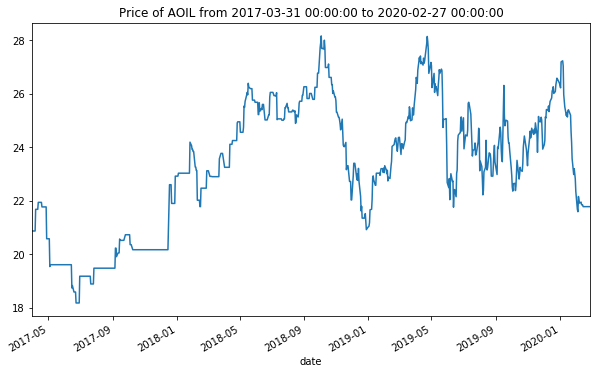

In [12]:
#Plot of asset historical closing price
df['adjClose'].plot(figsize=(10, 6), title = "Price of {} from {} to {}".format(ticker, df.index.min(), df.index.max()))

# Geometric Brownian Motion

We assume the log of the returns (percent changes) are normally distributed. We also assume the market is efficient. 

The formula for the change in price between periods is the price of the stock in $t_0$ multiplied by the expected drift (average change in price) plus an exogenous shock. 
$$\Delta S = S * (\mu \Delta t + \sigma \epsilon * \sqrt{\Delta t}) $$
Where:

$S$ = stock price 

$\Delta S$ = change in stock price 

$\mu$ = expected return 

$\sigma$ = standard deviation of the returns 

$\epsilon$ = random variable 

$\delta t$ = elapsed time 

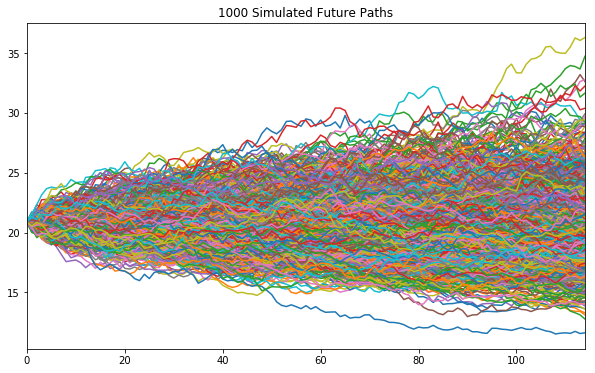

In [13]:
pred_end_date = datetime.datetime(2020, 6, 20)
forecast_dates = [d if d.isoweekday() in range(1, 6) else np.nan for d in pd.date_range(df.index.max(), pred_end_date)] 
intervals = len(forecast_dates)
iterations = 1000
#Preparing log returns from data
log_returns = np.log(1 + df['adjClose'].pct_change())

#Setting up drift and random component in relation to asset data
u = log_returns.mean()
var = log_returns.var()
drift = u - (0.5 * var)
stdev = log_returns.std()
daily_returns = np.exp(drift + stdev * norm.ppf(np.random.rand(intervals, iterations)))

#Takes last data point as startpoint point for simulation
S0 = df['adjClose'].iloc[-1]
price_list = np.zeros_like(daily_returns)
price_list[0] = S0
#Applies Monte Carlo simulation in asset
for t in range(1, intervals):
    price_list[t] = price_list[t - 1] * daily_returns[t]

forecast_df = pd.DataFrame(price_list)
    

forecast_df.plot(figsize=(10,6), legend=False, title = "{} Simulated Future Paths".format(iterations))


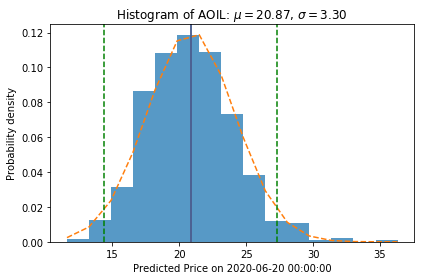

In [14]:
# Plotting with a histogram

x = forecast_df.values[-1]
sigma = np.std(x)
mu = np.mean(x)

num_bins = 15

fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(x, num_bins, density=1, alpha=.75)

# add a 'best fit' line
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--')
ax.axvline(np.mean(x), color='r')
ax.axvline(mu+sigma*1.96, color='g', ls='--')
ax.axvline(mu-sigma*1.96, color='g', ls='--')
ax.axvline(S0)
ax.set_xlabel('Predicted Price on {}'.format(pred_end_date))
ax.set_ylabel('Probability density')
ax.set_title(r'Histogram of {ticker}: $\mu={mu:.02f}$, $\sigma={sigma:.02f}$'.format(ticker = ticker, mu=mu, sigma=sigma))

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

# More advanced graphing

The data frame we created for the simulations held each run as a separate column. This is called `wide` format which is useful for some analytics tasks, but is not optimal for visualization. We use a technique called `pd.melt` to collages the 1000 columns into three. This new format, called `long`, is aligned with the principles of `tidy data`. 

## Plotly
Plotly is a high level library for interactive visualization. It is a "declarative" library where we say what we want, not how to produce what we want. Notice that the code for this visualization is much smaller thn the code for Matplotlib, and yet, the result is much better. 

In [15]:
forecast_df['date'] = [df.index.max()+pd.Timedelta(days=i) for i in forecast_df.index]
forecast_df.set_index('date', inplace=True)

df['Source'] = 'Actual'
forecast_df['Source'] = 'Forecast'
result = forecast_df.append(df[['adjClose', 'Source']], sort=False)

r = result.reset_index()
r = pd.melt(r, id_vars=['Source', 'date'])

In [18]:
forecast_df.head()

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,Source
date,,,,,,,,,,,,,,,,,,,,,
2020-02-27,20.870000,20.870000,20.870000,20.870000,20.870000,20.870000,20.870000,20.870000,20.870000,20.870000,...,20.870000,20.870000,20.870000,20.870000,20.870000,20.870000,20.870000,20.870000,20.870000,Forecast
2020-02-28,20.755847,20.709537,20.719488,20.964492,20.596313,20.722307,20.980395,20.407180,21.129776,21.410890,...,20.809500,20.591001,21.057753,20.970052,21.062148,20.472625,20.698384,20.539711,21.298725,Forecast
2020-02-29,21.073922,20.641747,21.192885,21.145950,20.623098,20.610935,21.069662,20.751962,21.374070,21.114220,...,20.631525,20.476017,21.031494,21.975934,21.061725,20.615630,20.847504,20.841736,21.082879,Forecast
2020-03-01,21.288356,20.713704,21.467695,21.438542,20.955454,21.149758,21.151166,20.645041,21.259832,21.315923,...,21.544918,20.886498,20.697863,21.523059,21.526520,20.687939,20.841801,20.684254,21.529674,Forecast
2020-03-02,21.764562,20.426887,21.747810,21.082088,20.586188,21.333594,21.570603,20.523313,21.020645,21.115118,...,21.515983,21.071730,21.162954,22.363050,21.474377,21.239554,20.721370,20.158944,21.466373,Forecast


In [19]:
r.head()

,Source,date,variable,value
0,Forecast,2020-02-27,0,20.870000
1,Forecast,2020-02-28,0,20.755847
2,Forecast,2020-02-29,0,21.073922
3,Forecast,2020-03-01,0,21.288356
4,Forecast,2020-03-02,0,21.764562
